In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

%matplotlib inline

### Dataset

In this homework, we will use the California Housing Prices from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices).

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
```

The goal of this homework is to create a regression model for predicting housing prices (column `'median_house_value'`).


### Preparing the dataset 

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2.

First, keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`

Preparation:

* Apply the log tranform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframe into matrices.

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv'
!wget $data

--2023-10-17 14:42:02--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1,4M) [text/plain]
Saving to: ‘housing.csv.1’

housing.csv.1       100%[===================>]   1,36M  --.-KB/s    in 0,1s    

2023-10-17 14:42:03 (11,9 MB/s) - ‘housing.csv.1’ saved [1423529/1423529]



In [3]:
df = pd.read_csv('housing.csv')
df = df.loc[(df['ocean_proximity'] == '<1H OCEAN') | (df['ocean_proximity'] == 'INLAND')]
df['median_house_value'] = np.log1p(df['median_house_value'].values)
df.fillna(0, inplace=True)

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

y_train = df_train['median_house_value'].values
y_test = df_test['median_house_value'].values
y_val = df_val['median_house_value'].values

del df_train['median_house_value']
del df_test['median_house_value']
del df_val['median_house_value']

train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=True)
dv.fit(train_dict)

X_train = dv.transform(train_dict)
X_val = dv.transform(val_dict)

## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `ocean_proximity` +
* `total_rooms`
* `latitude`
* `population`

In [4]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.045
* 0.245 +
* 0.545
* 0.845

In [5]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
rmse = sqrt(mse)
round(rmse, 3)

0.245

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?

- 10
- 25
- 50 
- 160 +

In [6]:
rmses = {}

for n_estimators in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = sqrt(mean_squared_error(y_val, y_pred))
    rmses[n_estimators] = round(rmse, 3)
    
rmses

{10: 0.245,
 20: 0.239,
 30: 0.237,
 40: 0.235,
 50: 0.235,
 60: 0.234,
 70: 0.234,
 80: 0.234,
 90: 0.234,
 100: 0.234,
 110: 0.234,
 120: 0.234,
 130: 0.234,
 140: 0.233,
 150: 0.233,
 160: 0.233,
 170: 0.233,
 180: 0.233,
 190: 0.234,
 200: 0.234}

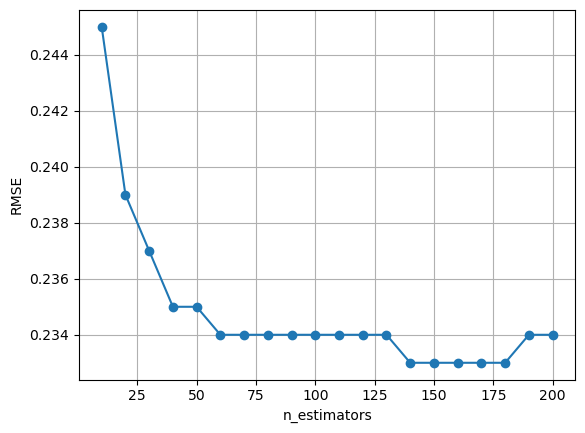

In [7]:
plt.plot(list(rmses.keys()), list(rmses.values()), marker='o')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`


What's the best `max_depth`:

* 10
* 15
* 20 +
* 25

In [8]:
results = {}

for max_depth in [10, 15, 20, 25]:
    min_rmse = float('inf')
    for n_estimators in range(10, 201, 10):
        rf = RandomForestRegressor(
            max_depth=max_depth, 
            n_estimators=n_estimators,
            random_state=1, 
            n_jobs=-1
        )
        
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict(X_val)
        
        rmse = sqrt(mean_squared_error(y_val, y_pred))
        
        if rmse < min_rmse:
            min_rmse = rmse
    
    results[max_depth] = round(min_rmse, 4)
    
print(results)

{10: 0.2446, 15: 0.2342, 20: 0.2334, 25: 0.2335}


# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model

What's the most important feature? 

* `total_rooms`
* `median_income` +	
* `total_bedrooms`
* `longitude`

In [9]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
feature_names = dv.get_feature_names_out()
feature_importances = dict(zip(feature_names, importances))

print(max(feature_importances.items(), key=lambda k: k[1]))

('median_income', 0.3355634945747331)


## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3 +
* 0.1
* Both gives same 

In [10]:
!pip install xgboost

In [11]:
features = dv.get_feature_names_out().tolist()
cleaned_features = [feat.replace('<', '_').replace('=', '_') for feat in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=cleaned_features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=cleaned_features)

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

watchlist = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(xgb_params,
                  dtrain,
                  evals=watchlist,
                  num_boost_round=100)

y_pred = model.predict(dval)

sqrt(mean_squared_error(y_val, y_pred))

[0]	train-rmse:0.44350	val-rmse:0.44250
[1]	train-rmse:0.36599	val-rmse:0.36916
[2]	train-rmse:0.31556	val-rmse:0.32382
[3]	train-rmse:0.28541	val-rmse:0.29965
[4]	train-rmse:0.26573	val-rmse:0.28417
[5]	train-rmse:0.25338	val-rmse:0.27463
[6]	train-rmse:0.24157	val-rmse:0.26770
[7]	train-rmse:0.23486	val-rmse:0.26423
[8]	train-rmse:0.22668	val-rmse:0.25820
[9]	train-rmse:0.21995	val-rmse:0.25444
[10]	train-rmse:0.21444	val-rmse:0.25179
[11]	train-rmse:0.21155	val-rmse:0.25054
[12]	train-rmse:0.20729	val-rmse:0.24791
[13]	train-rmse:0.20317	val-rmse:0.24628
[14]	train-rmse:0.20135	val-rmse:0.24630
[15]	train-rmse:0.19858	val-rmse:0.24522
[16]	train-rmse:0.19580	val-rmse:0.24445
[17]	train-rmse:0.19333	val-rmse:0.24395
[18]	train-rmse:0.19107	val-rmse:0.24284
[19]	train-rmse:0.18735	val-rmse:0.24127
[20]	train-rmse:0.18524	val-rmse:0.23978
[21]	train-rmse:0.18332	val-rmse:0.23963
[22]	train-rmse:0.18189	val-rmse:0.23892
[23]	train-rmse:0.18006	val-rmse:0.23847
[24]	train-rmse:0.17869	va

0.228623199980106

In [12]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params,
                  dtrain,
                  evals=watchlist,
                  num_boost_round=100)

y_pred = model.predict(dval)

sqrt(mean_squared_error(y_val, y_pred))

[0]	train-rmse:0.52449	val-rmse:0.52045
[1]	train-rmse:0.48736	val-rmse:0.48443
[2]	train-rmse:0.45433	val-rmse:0.45293
[3]	train-rmse:0.42533	val-rmse:0.42550
[4]	train-rmse:0.39987	val-rmse:0.40144
[5]	train-rmse:0.37822	val-rmse:0.38151
[6]	train-rmse:0.35887	val-rmse:0.36393
[7]	train-rmse:0.34177	val-rmse:0.34838
[8]	train-rmse:0.32701	val-rmse:0.33492
[9]	train-rmse:0.31411	val-rmse:0.32333
[10]	train-rmse:0.30326	val-rmse:0.31427
[11]	train-rmse:0.29355	val-rmse:0.30615
[12]	train-rmse:0.28519	val-rmse:0.29922
[13]	train-rmse:0.27760	val-rmse:0.29269
[14]	train-rmse:0.27116	val-rmse:0.28796
[15]	train-rmse:0.26538	val-rmse:0.28380
[16]	train-rmse:0.26012	val-rmse:0.27970
[17]	train-rmse:0.25583	val-rmse:0.27661
[18]	train-rmse:0.25203	val-rmse:0.27388
[19]	train-rmse:0.24818	val-rmse:0.27123
[20]	train-rmse:0.24512	val-rmse:0.26882
[21]	train-rmse:0.24149	val-rmse:0.26669
[22]	train-rmse:0.23895	val-rmse:0.26478
[23]	train-rmse:0.23594	val-rmse:0.26331
[24]	train-rmse:0.23305	va

0.23208927121609343